# Data Analysis

### Info
This log is part of the experiment 20139026 at beamline DiProi at Fermi/Trieste (Oct.2017).  

Uses: /src/data_tools.py and /src/fit_tools.py

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
import h5py
import sys

sys.path.insert(0, '../src/')
from data_tools import *
from fit_tools import *

### Load data

costants and parameters

In [2]:
run = 19
t0 = 136.35
c = 299792458 #m/s
i0_thr = 2e5

discover and sort energy folders

In [3]:
base_path = '/Volumes/FERMI_2017/DATA/XAS%03d/' % run
folders,tmp = discover_files(base_path)

energies = []
e_folders = []
for i in range(len(folders)):
    if folders[i][:2]=='E2':
        e = float('%s.%s'%(folders[i][1:4],folders[i][5:7]))
        energies.extend([e])
        e_folders.extend([folders[i]])
n_energies = len(energies)
energies_sorted = np.sort(energies)
e_folders_sorted = [x for _,x in sorted(zip(energies,e_folders))]

Load data: For each shots are loaded 
* the FEL intensity (i0)
* the XAS intensity
* the delay time  
* the photon energy (average)

In [4]:
FEL_int  = [] 
XAS_int  = [] 
t_delay  = [] 
mean_E   = [] 
delays   = []

# loop over energies and delay times and load
for i in range(n_energies):
    load_path = base_path+e_folders_sorted[i]+'/work/'
    tmp,file_names = discover_files(load_path)
    #print 'E:%d/%d - %s '%(i+1,n_energies,e_folders_sorted[i])
    for j in range(len(file_names)):
            #print 'E:%d/%d - t:%d/%d - %s '%(i+1,len(e_folders_sorted),j+1,len(file_names),file_names[j])
            h5file = h5py.File(load_path+file_names[j], 'r')
            XAS = h5file['/XAS/intensity'].value
            t   = h5file['/LASER/delay'].value
            i0  = h5file['/FEL/i0'].value
            n_shots = len(XAS)
            XAS_int.extend(XAS)
            FEL_int.extend(i0)
            mean_E.extend(np.ones(n_shots)*energies_sorted[i])
            t_delay.extend(np.ones(n_shots)*t)
            delays.extend([t])
            
FEL_int  = np.array(FEL_int) 
XAS_int  = np.array(XAS_int)
t_delay  = np.array(t_delay)
mean_E   = np.array(mean_E)
delays   = np.array(delays)
delays= np.unique(np.sort(delays[delays>0]))

### XAS pump probe signal

Calculate the XAS pump probe signal

In [7]:
XAS_spectrum = np.zeros([n_energies,len(delays)])
XAS_error = np.zeros([n_energies,len(delays)])

for i in range(n_energies):
    t_E,i0_E,i1_E = t_delay[mean_E==energies_sorted[i]],FEL_int[mean_E==energies_sorted[i]],XAS_int[mean_E==energies_sorted[i]]
    for j in range(len(delays)):
        i0,i1 = i0_E[t_E==delays[j]],i1_E[t_E==delays[j]]
        pp = i1[i0>i0_thr]/i0[i0>i0_thr]
        XAS_spectrum[i,j] = np.average(pp)
        XAS_error[i,j] = np.average(pp)/np.sqrt(len(pp))
    
# convert from mm to ps
times = (delays-t0)/c*1e9*2
n_times = len(times)

Make Plots. Note that according to literature:
* Gas phase spectrum : 287.4 eV
* Adsorbed spectrum :  287.8 eV

To match the absolute values one needs to calibrate the energy axis, but can compare the relative shift, which is about 0.4 eV.  


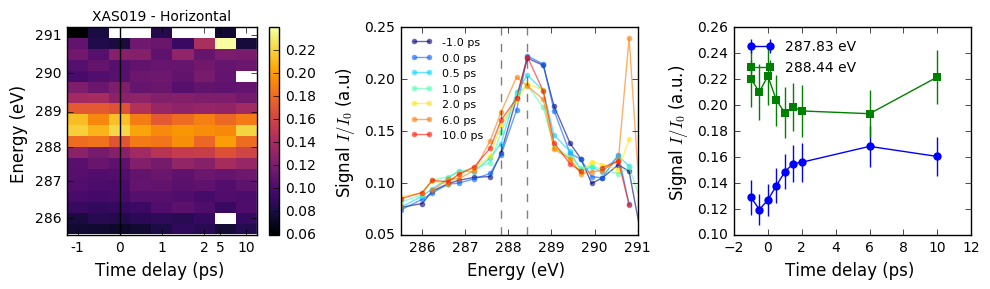

In [6]:
x1,x2 = 7,9 # energies to plot the pump-probe time series

plt.figure(figsize=[10,3])

# -- fig 1
plt.subplot(1,3,1)
plt.imshow(XAS_spectrum,aspect='auto',interpolation='None',origin='lower',cmap='inferno',vmin=0.06)

fE = interpolate.interp1d(energies_sorted,np.arange(n_energies))
E_ticks =np.arange(286,292)
y_ticks = fE(E_ticks)
ft = interpolate.interp1d(times,np.arange(n_times))
t_ticks =np.array([-1,0,1,2,5,10])
x_ticks = ft(t_ticks)
plt.yticks(y_ticks,E_ticks)
plt.xticks(x_ticks,t_ticks)
plt.title('XAS%03d - Horizontal'%run,size=10)
plt.axvline(x=x_ticks[t_ticks==0],c='black')
plt.colorbar()
plt.xlabel(r'Time delay (ps) ',size=12)
plt.ylabel(r'Energy (eV) ',size=12)

# -- fig 2

plt.subplot(1,3,2)
for i in [0,2,3,4,6,7,8]:#range(n_times):
    color_index = float(i)/(len(delays))
    color = plt.cm.jet(color_index)
    plt.plot(energies_sorted,XAS_spectrum[:,i],'-o',color=color,ms=4,
             alpha=0.6,markeredgewidth=0.0,label='%.1f ps'%times[i])
plt.axvline(x=energies_sorted[x1],ls='--',c='black',alpha=0.5)
plt.axvline(x=energies_sorted[x2],ls='--',c='black',alpha=0.5)
plt.legend(frameon=False,loc='upper left', prop={'size': 8})
plt.ylabel(r'Signal $I/I_0$ (a.u) ',size=12)
plt.xlabel(r'Energy (eV) ',size=12)
plt.xlim(285.5,291)
plt.ylim(0.05,0.25)


# -- fig 3
plt.subplot(1,3,3)
plt.errorbar(times,XAS_spectrum[x1],yerr=XAS_error[x1],fmt='o-',
             label='%.2f eV'%energies_sorted[x1],markeredgewidth=0.0)
plt.errorbar(times,XAS_spectrum[x2],yerr=XAS_error[x2],fmt='s-',
             label='%.2f eV'%energies_sorted[x2],markeredgewidth=0.0)

plt.legend(frameon=False,loc='upper left', prop={'size': 10})
plt.ylabel(r'Signal $I/I_0$ (a.u.) ',size=12)
plt.xlabel(r'Time delay (ps) ',size=12)
plt.tight_layout()
plt.savefig('/Users/fivos/Desktop/XAS_%03d_Hor.png'%run,dpi=300)

plt.show()